## System setup

---


##### Importing modules


In [1]:
import os
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})

import cv2 as cv

from tensorflow.keras.layers import (
    Rescaling,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from tqdm import tqdm, trange

from toolkit.classes import Environment, ImageProcessor, Augmenter, Model

2023-01-02 11:46:34.397306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 11:46:34.813246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/demust/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-02 11:46:34.813281: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-02 11:46:36.003964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

##### Setting up environment


In [2]:
env = Environment()


## Read dataset

---


##### Create image dataframe


In [3]:
images = pd.DataFrame(
    {
        "type": pd.Series(dtype="str"),
        "defect": pd.Series(dtype="int"),
        "defect_str": pd.Series(dtype="str"),
        "path": pd.Series(dtype="str"),
        "filename": pd.Series(dtype="str"),
        "img": pd.Series(dtype="str"),
        "height": pd.Series(dtype="int"),
        "width": pd.Series(dtype="int"),
        "components": pd.Series(dtype="int"),
        "R_mean": pd.Series(dtype="float"),
        "G_mean": pd.Series(dtype="float"),
        "B_mean": pd.Series(dtype="float"),
    }
)

for each in env.DATA_PATH:
    p = each.split("/")
    y = 1 if p[3] == "Defective" else 0
    for img in os.listdir(each):
        data = {
            "type": p[2].lower(),
            "defect": y,
            "defect_str": p[3],
            "path": each,
            "filename": img,
            "img": os.path.join(each, img),
            "height": 0,
            "width": 0,
            "components": 0,
            "R_mean": 0,
            "G_mean": 0,
            "B_mean": 0,
        }
        df = pd.DataFrame(data=data, index=[1])
        images = pd.concat([images, df])

images.reset_index(inplace=True, drop=True)
display(images)


,type,defect,defect_str,path,filename,img,height,width,components,R_mean,G_mean,B_mean
0,train,0,Non defective,./data/Train/Non defective/,97.jpg,./data/Train/Non defective/97.jpg,0,0,0,0.0,0.0,0.0
1,train,0,Non defective,./data/Train/Non defective/,79.jpg,./data/Train/Non defective/79.jpg,0,0,0,0.0,0.0,0.0
2,train,0,Non defective,./data/Train/Non defective/,114.jpg,./data/Train/Non defective/114.jpg,0,0,0,0.0,0.0,0.0
3,train,0,Non defective,./data/Train/Non defective/,18.jpg,./data/Train/Non defective/18.jpg,0,0,0,0.0,0.0,0.0
4,train,0,Non defective,./data/Train/Non defective/,46.jpg,./data/Train/Non defective/46.jpg,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
379,test,1,Defective,./data/Test/Defective/,381.jpg,./data/Test/Defective/381.jpg,0,0,0,0.0,0.0,0.0
380,test,1,Defective,./data/Test/Defective/,379.jpg,./data/Test/Defective/379.jpg,0,0,0,0.0,0.0,0.0
381,test,1,Defective,./data/Test/Defective/,377.jpg,./data/Test/Defective/377.jpg,0,0,0,0.0,0.0,0.0
382,test,1,Defective,./data/Test/Defective/,380.jpg,./data/Test/Defective/380.jpg,0,0,0,0.0,0.0,0.0


## Data augmentation

---


In [4]:
N_augmented = 25

image_augmenter = Augmenter(N_augmented, images)
image_augmenter.remove_old_data(env.augmented_folder)
image_augmenter.augment_images()
augmented_images = image_augmenter.save_dataframe()
del image_augmenter
augmented_images


,type,defect,defect_str,path,filename,img,height,width,components,R_mean,G_mean,B_mean
0,train,0,Non defective,./augmented/Train/Non defective,19_augmented.jpg,./augmented/Train/Non defective/19_augmented.jpg,2998,3997,3,133.050140,135.709119,134.635613
1,train,0,Non defective,./augmented/Train/Non defective,59_augmented.jpg,./augmented/Train/Non defective/59_augmented.jpg,3000,4000,3,81.365692,91.374687,98.037292
2,train,0,Non defective,./augmented/Train/Non defective,93_augmented.jpg,./augmented/Train/Non defective/93_augmented.jpg,3000,4000,3,109.666338,111.827606,111.279247
3,train,0,Non defective,./augmented/Train/Non defective,112_augmented.jpg,./augmented/Train/Non defective/112_augmented.jpg,3000,4000,3,83.208932,85.827406,86.765972
4,train,0,Non defective,./augmented/Train/Non defective,102_augmented.jpg,./augmented/Train/Non defective/102_augmented.jpg,3106,4142,3,101.934118,113.137672,121.176731
5,train,0,Non defective,./augmented/Train/Non defective,72_augmented.jpg,./augmented/Train/Non defective/72_augmented.jpg,3000,4000,3,118.646478,128.710229,133.861525
6,train,0,Non defective,./augmented/Train/Non defective,113_augmented.jpg,./augmented/Train/Non defective/113_augmented.jpg,3000,4000,3,109.130673,116.043363,119.896980
7,train,0,Non defective,./augmented/Train/Non defective,5_augmented.jpg,./augmented/Train/Non defective/5_augmented.jpg,3326,4435,3,111.343687,123.584368,129.670575
8,train,0,Non defective,./augmented/Train/Non defective,129_augmented.jpg,./augmented/Train/Non defective/129_augmented.jpg,2705,3455,3,83.608363,98.618681,113.642622
9,train,0,Non defective,./augmented/Train/Non defective,145_augmented.jpg,./augmented/Train/Non defective/145_augmented.jpg,3000,4000,3,112.244211,121.963906,129.095190


## Image processing

---


In [4]:
img_height = 128  
img_width = 128

preprocessing_steps = [
    "original",
    "crop",
    "grayscale",
    "hist_eq",
    "noise_filt",
    "resize",
    "save",
]

preprocessing_kwargs = {
    "crop": {"ratio": 0.1},
    "resize": {"height": img_height, "width": img_width},
    "hist_eq": {
        "type": "CLAHE",
        "size": (16, 16),
    },
    "noise_filt": {"type": "median", "size": 11},
    "Laplacian": {"size": 5},
    "Canny": {"low": 100, "high": 200},
    "Hough": {"minLineLength": 10, "maxLineGap": 20},
    "feat_detect": {"type": "ORB"},
}


In [8]:
image_processor = ImageProcessor(preprocessing_steps, preprocessing_kwargs)
image_processor.remove_old_data(env.preprocessed_folder)
image_processor.process_images(images)
image_processor.process_images(augmented_images)
del image_processor


## Model build

---


##### Construct neural network


In [5]:
CNN = Model(img_height, img_width)

CNN.epochs = 100
CNN.batch_size = 32

CNN.model = Sequential(
    [
        Rescaling(1.0 / 255, input_shape=(img_height, img_width, 1)),
        # Conv2D(
        #     64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        # ),
        # Conv2D(
        #     64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        # ),
        # BatchNormalization(),
        # MaxPooling2D(),
        # Dropout(0.2),
        # Conv2D(
        #     64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        # ),
        # Conv2D(
        #     64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        # ),
        # BatchNormalization(),
        # MaxPooling2D(),
        # Dropout(0.2),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.4),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        Conv2D(
            64, 3, padding="same", activation="relu", kernel_initializer="he_uniform"
        ),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.5),
        Flatten(),
        Dense(units=int(img_height * img_width / 2), activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ]
)

CNN.setup_neural_net()
CNN.model.summary()


2023-01-02 11:46:51.074750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-02 11:46:51.074775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomcom): /proc/driver/nvidia/version does not exist
2023-01-02 11:46:51.075544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 11:46:51.269528: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2023-01-02 11:46:51.324631: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system m

Found 350 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 22 files belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
    

##### Train


In [6]:
CNN.train_net()


Epoch 1/100


2023-01-02 11:46:59.805958: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2023-01-02 11:46:59.821132: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


11/11 [==============================] - 42s 3s/step - loss: 2.8129 - binary_accuracy: 0.5114 - val_loss: 14.4166 - val_binary_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 36s 3s/step - loss: 2.8987 - binary_accuracy: 0.5457 - val_loss: 8.1402 - val_binary_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 34s 3s/step - loss: 2.2010 - binary_accuracy: 0.6057 - val_loss: 5.0628 - val_binary_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 31s 3s/step - loss: 1.6114 - binary_accuracy: 0.6314 - val_loss: 24.1019 - val_binary_accuracy: 0.5000
Epoch 5/100
11/11 [==============================] - 33s 3s/step - loss: 1.0926 - binary_accuracy: 0.6229 - val_loss: 3.5449 - val_binary_accuracy: 0.5000
Epoch 6/100
11/11 [==============================] - 32s 3s/step - loss: 0.8275 - binary_accuracy: 0.6886 - val_loss: 17.6868 - val_binary_accuracy: 0.5000
Epoch 7/100
11/11 [==============================] - 31s 3s/step - loss: 0.7445

##### Predict


In [7]:
CNN.predict_test()


1/1 [==============================] - 1s 1s/step
Test values:          [0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0]
Predicted values:     [1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1]


##### Metrics


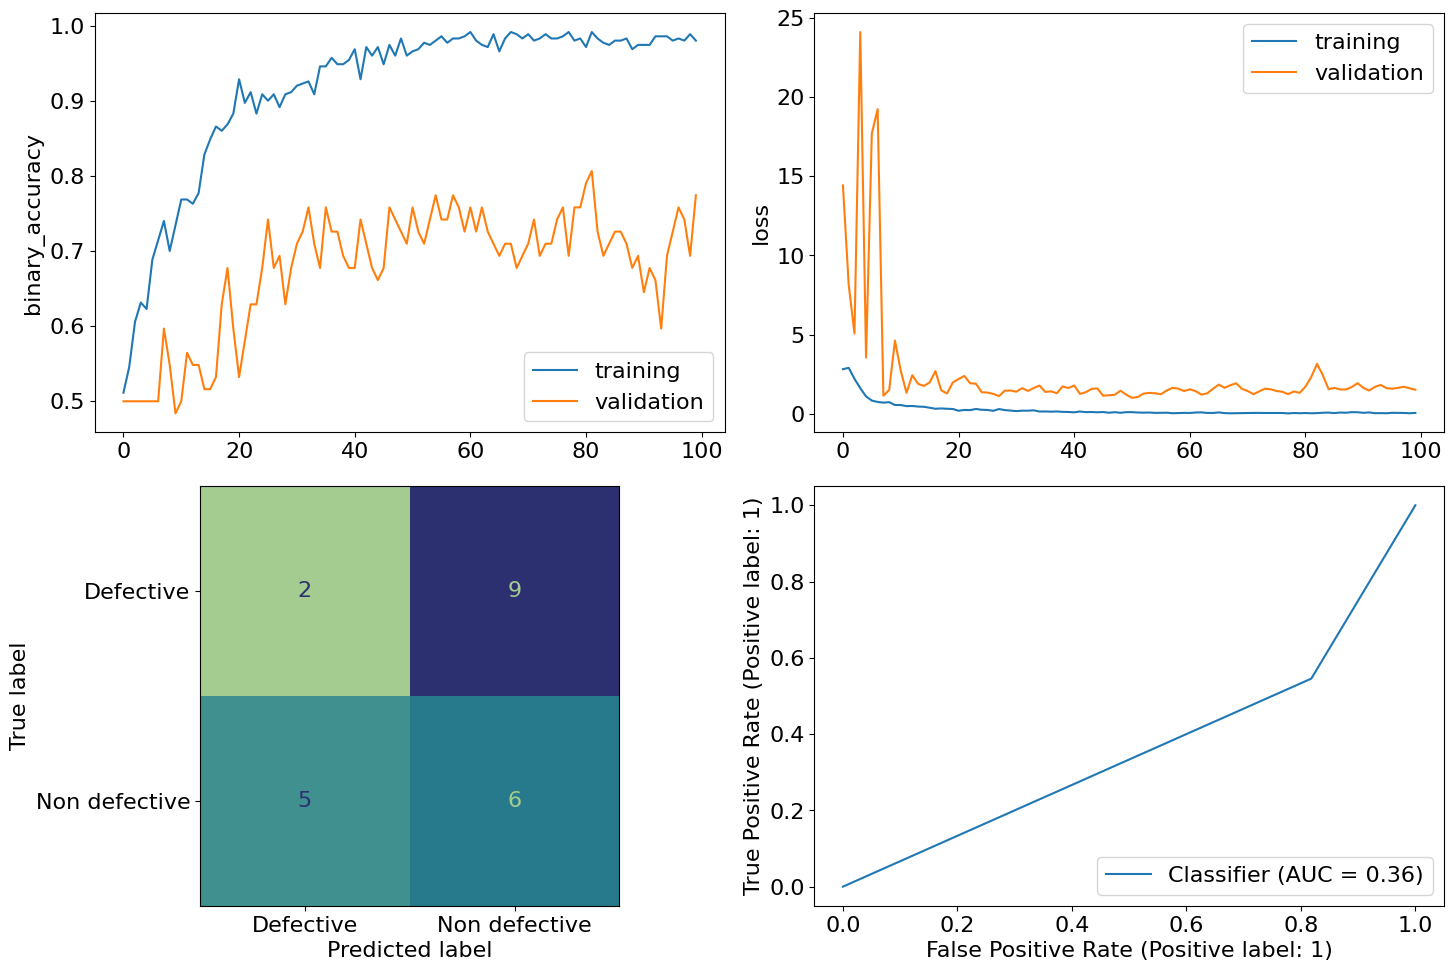

In [8]:
CNN.show_metrics()
